In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
!pip install openpyxl
from collections import defaultdict
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import LogNorm

# Parameters

In [2]:
save = False
input_clustering = '_new' # '_new' or ''
optimal_cluster = 'st_cluster_final_gid' # 'st_cluster_final_gid' or 'st_cluster_3_5_7'

test_case = 'block'
historic_ref = '' # '_Full' '_Discount' or ''
premium_type = '' # '_Full'  '_Discount' or ''

use_reinsurance = True
base_case = ''
if use_reinsurance == False:
    base_case = '_base_case'

In [3]:
if test_case == 'historic':
    simulations = 1
else:
    steps = 100
    simulations = 1000

# Data Load

## Simulations

In [4]:
# Simulation data
state_balance_df = pd.read_csv(f'Results/state_balance_{test_case}{input_clustering}{premium_type}{base_case}.csv')
final_balances_df = pd.read_csv(f'Results/final_balances_{test_case}{input_clustering}{premium_type}{base_case}.csv')
cluster_state_df = pd.read_csv(f'Results/cluster_state_{test_case}{input_clustering}{premium_type}{base_case}.csv')
balance_transition_df = pd.read_csv(f'Results/balance_transition_{test_case}{input_clustering}{premium_type}{base_case}.csv')

# Historic data
state_balance_df_hist = pd.read_csv(f'Results/state_balance_historic{input_clustering}{historic_ref}.csv')

## Geospatial

In [5]:
# Geospatial data
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)
gdf_states["STATEFP"] = pd.to_numeric(gdf_states["STATEFP"], errors="coerce").astype("Int64")

## NFIP Clustered Claims

In [6]:
if input_clustering == '_new':
    clustered_claims = pd.read_csv("../2_Low_Return_Period/new_clusters_9.24.25.csv")
    optimal_cluster = 'st_cluster_final_gid'
else:
    clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")

clustered_claims['countyCode']=clustered_claims['countyCode'].apply(lambda x: str(x).zfill(5))
clustered_claims['stateCode']=clustered_claims['countyCode'].str[:2]

/tmp/ipykernel_380/1877075091.py:2: DtypeWarning: Columns (7,51,66) have mixed types. Specify dtype option on import or set low_memory=False.
  clustered_claims = pd.read_csv("../2_Low_Return_Period/new_clusters_9.24.25.csv")


In [7]:
# Create the new field 'percentageDamageAmount'
clustered_claims['percentageBuildingDamageAmount'] = ((clustered_claims['buildingDamageAmount'] / clustered_claims['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
clustered_claims['totalClaimPaid'] = clustered_claims['amountPaidOnBuildingClaim'].fillna(0) + clustered_claims['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
clustered_claims = clustered_claims[clustered_claims['stateOwnedIndicator'] != True]

In [8]:
# Load CPI data
CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"]) 

# Ensure 'CPIAUCSL' is numeric
CPI_insurance["CPIAUCSL"] = pd.to_numeric(CPI_insurance["CPIAUCSL"], errors="coerce")

# Handle missing or non-numeric values by forward and backward filling
CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
CPI_insurance["CPIAUCSL"].fillna(method="bfill", inplace=True)

# Extract year and calculate annual average CPI
CPI_insurance['Year'] = CPI_insurance["DATE"].dt.year
CPI_insurance = CPI_insurance.groupby('Year')["CPIAUCSL"].mean().reset_index()
CPI_insurance = CPI_insurance.rename(columns={"CPIAUCSL": "CPI"})

# Base CPI for adjustment (e.g., 2024)
BASE_CPI = 313.3

# Filter claims to only include those from 1998 to present
clustered_claims['dateOfLoss'] = pd.to_datetime(clustered_claims['dateOfLoss'])

# Extract month (abbreviated) and year from 'dateOfLoss'
clustered_claims.loc[:, 'yearOfLoss'] = clustered_claims['dateOfLoss'].dt.year

# Merge clustered_claims with CPI_insurance on month (abbreviation) and year
claims_merged = pd.merge(clustered_claims, CPI_insurance, left_on=['yearOfLoss'], right_on=['Year'])

# Create 'adjustedClaim' column by dividing the CPI for May 2024 by the CPI at the time of loss, and multiplying by 'totalClaimPaid'
claims_merged['adjustedClaim'] = (BASE_CPI / claims_merged['CPI']) * claims_merged['totalClaimPaid']

# Drop unnecessary columns and keep relevant ones
adjusted_claims = claims_merged[['dateOfLoss', 'totalClaimPaid', 'adjustedClaim', 'yearOfLoss']]

clustered_claims = claims_merged

/tmp/ipykernel_380/2656989844.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_380/2656989844.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_380/2656989844.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inp

## NFIP Policies

In [9]:
if premium_type == '_Full':
    risk_policies = pd.read_excel('../Local_Data/NFIP_Data/updatedNFIPdata_2025.xlsx', sheet_name='2024')
    risk_policies['County Code'] = risk_policies['County Code'].astype(int).astype(str)
    risk_policies['County Code'] = risk_policies['County Code'].apply(lambda x: str(x).zfill(5))
    risk_policies['State'] = risk_policies['State Names'].str.strip().str.upper()
    risk_policies['Policies in Force'] = risk_policies['Policy Count']
    
    aggregated_risk_policies = risk_policies.groupby(['County Code', 'State']).agg({
        'Policies in Force': 'sum',
        'Total Written Premium + FPF': 'sum',
        'Total Annual Payment': 'sum'
    }).reset_index()

elif premium_type == '_Discount':
    risk_policies = pd.read_csv('../Local_Data/NFIP_Data/UpdatedNFIPData_2024_V4.csv')
    risk_policies['countyCode'] = risk_policies['countyCode'].astype(int).astype(str)
    risk_policies['countyCode'] = risk_policies['countyCode'].apply(lambda x: str(x).zfill(5))
    risk_policies['State'] = risk_policies['State Name'].str.strip().str.upper()
    risk_policies['Policies in Force'] = risk_policies['TotalPolicies']
    risk_policies['Total Written Premium + FPF'] = risk_policies['actualPremium'] + risk_policies['federalPolicyFee']
    
    aggregated_risk_policies = risk_policies.groupby(['countyCode', 'State']).agg({
        'Policies in Force': 'sum',
        'Total Written Premium + FPF': 'sum',
        'Total Annual Payment': 'sum'
    }).reset_index()

else:
    risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

    risk_policies['County'] = risk_policies['County'].str.strip()
    risk_policies['State'] = risk_policies['State'].str.strip()
    
    aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
        'Policies in Force': 'sum',
        'Total Written Premium + FPF': 'sum',
        'Total Annual Payment': 'sum'
    }).reset_index()

In [10]:
# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

In [11]:
# Abbreviation mapping (if needed)
state_abbrev = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO',
    '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI',
    '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY',
    '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN',
    '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH',
    '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD',
    '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA',
    '54': 'WV', '55': 'WI', '56': 'WY'
}

In [12]:
state_claims = pd.read_csv('../Local_Data/NFIP_Data/All_Claims_by_Year.csv')
state_claims = state_claims.groupby("State").aggregate({'Total Claim Dollars Paid':'mean','Total Paid Claims':'mean'}).reset_index()
state_claims['State'] = state_claims['State'].str.upper()
state_claims = state_claims.merge(state_df, left_on='State', right_on='State Name', how='left')
state_policies = aggregated_risk_policies.groupby("State").aggregate({
    'Policies in Force':'sum',
    'Total Written Premium + FPF':'sum',
    'Total Annual Payment':'sum'}).reset_index()
state_merged = state_claims.merge(state_policies, left_on='State', right_on='State', how='left')
state_merged['meanLoss'] = state_merged['Total Written Premium + FPF']-state_merged['Total Claim Dollars Paid']

# Merge the aggregated data with the shapefile
gdf_states = gdf_states.merge(state_merged, left_on='GEOID', right_on='State FIPS', how='left')

In [13]:
# Step 1: Compute total premium
total_premium = gdf_states["Total Written Premium + FPF"].sum()

# Step 2: Create a new column for percentage of total
gdf_states["Contribution %"] = 100 * gdf_states["Total Written Premium + FPF"] / total_premium

# Step 3: Create a new column for value of the pool
gdf_states["Benefit"] = 100 / gdf_states["Contribution %"]
gdf_states["OG_Benefit"] = gdf_states["Benefit"]
og_gain_balance = np.min(gdf_states["Benefit"])

# Step 4: Create a new column for the withdrawal max
gdf_states["Withdrawal_threshold"] = gdf_states["Total Written Premium + FPF"]*og_gain_balance
gdf_states["OG_Withdrawal_threshold"] = gdf_states["Withdrawal_threshold"]

# Remove AL and HI for simulation
gdf_states = gdf_states[~gdf_states['State'].isin(['ALASKA', 'HAWAII'])]

# Plotting

## Timeseries of State Pools

In [14]:
# Abbreviation mapping (if needed)
state_abbrev = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO',
    '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI',
    '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY',
    '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN',
    '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH',
    '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD',
    '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA',
    '54': 'WV', '55': 'WI', '56': 'WY'
}

# Selected state abbreviations
selected_states = ['LA', 'MS', 'AL', 'TX', 'NY', 'NJ', 'MO', 'OK', 'WV', 'ND', 'IA', 'MN', 'PA', 'FL', 'CA'] # TN, IL, NC, SD, KY, KS

# If state_balance_df is already a DataFrame:
state_year_df_hist = state_balance_df_hist.copy()

# Normalize STATEFP to zero-padded 2-char strings
state_year_df_hist["STATEFP"] = state_year_df_hist["STATEFP"].astype(str).str.extract(r"(\d+)", expand=False).str.zfill(2)

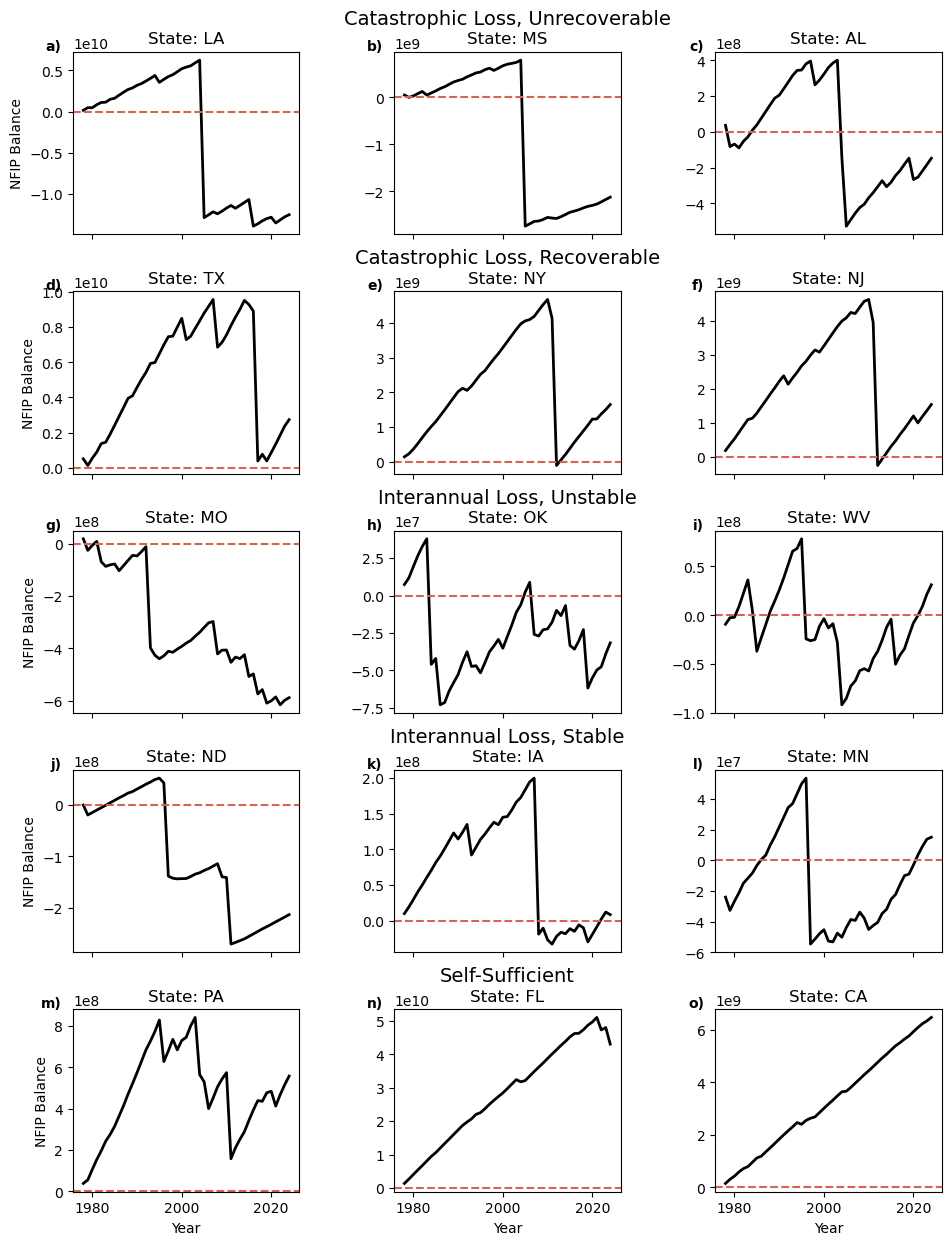

In [15]:
# Add abbreviation column
state_year_df_hist["STATEFP"] = state_year_df_hist["STATEFP"].astype(str).str.extract(r"(\d+)", expand=False).str.zfill(2)
state_year_df_hist["State"] = state_year_df_hist["STATEFP"].map(state_abbrev)

# Filter to selected states
filtered_df_hist = state_year_df_hist[state_year_df_hist["State"].isin(selected_states)].copy()

# Group by state and year across simulations, compute mean balance
state_balance_by_year_hist = (
    filtered_df_hist
    .groupby(["State", "year"])["contribution"]
    .sum()
    .groupby(level=0).cumsum()  # Cumulative NFIP balance by year
    .reset_index()
    .rename(columns={"contribution": "nfip_balance"})
)

# Prepare subplots
n_states = len(selected_states)
n_cols = 3
n_rows = -(-n_states // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.5 * n_rows), sharex=True, sharey=False)
axes = axes.flatten()

for i, state in enumerate(selected_states):
    ax = axes[i]
    df_sub = state_balance_by_year_hist[state_balance_by_year_hist["State"] == state]
    ax.plot(df_sub["year"], df_sub["nfip_balance"], color='black', linewidth=2)
    ax.axhline(0, color='#D8634E', linestyle='--')
    ax.set_title(f"State: {state}")

    # Subpanel label
    panel_label = f"{chr(97 + i)})"
    ax.text(-0.05, 1.07, panel_label,
            transform=ax.transAxes,
            fontsize=10,
            fontweight='bold',
            va='top',
            ha='right')

    row_idx = i // n_cols
    col_idx = i % n_cols
    if row_idx == n_rows - 1:
        ax.set_xlabel("Year")
    else:
        ax.set_xlabel("")

    if col_idx == 0:
        ax.set_ylabel("NFIP Balance")
    else:
        ax.set_ylabel("")

# Optional row titles (adjust as needed)
row_titles = [
    "Catastrophic Loss, Unrecoverable",
    "Catastrophic Loss, Recoverable",
    "Interannual Loss, Unstable",
    "Interannual Loss, Stable",
    "Self-Sufficient"
]

for row_idx in range(n_rows):
    mid_col_idx = row_idx * n_cols + 1
    if mid_col_idx < len(axes):
        ax = axes[mid_col_idx]
        ax.annotate(
            row_titles[row_idx],
            xy=(0.5, 1.13),
            xycoords='axes fraction',
            ha='center',
            va='bottom',
            fontsize=14
        )

plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0.05, 0, 1, 1])
if save:
    plt.savefig(f"Plots/New/SI/Balance_Timeseries_Historic.png", dpi=500, bbox_inches='tight')
plt.show()

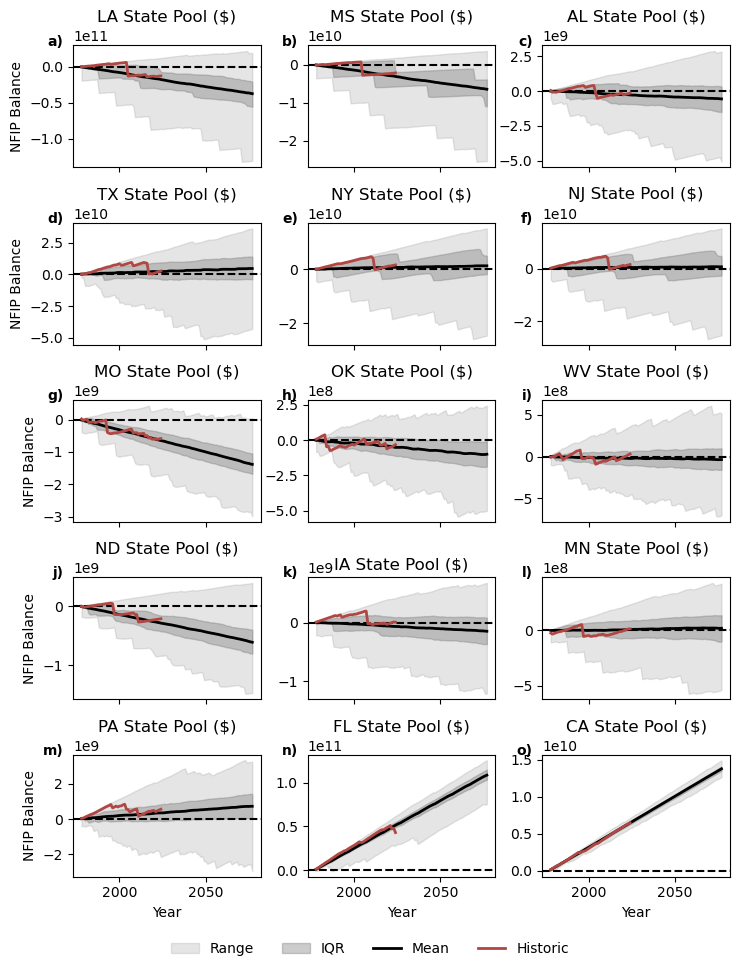

In [16]:
# If state_balance_df is already a DataFrame:
state_year_df = state_balance_df.copy()

# Normalize STATEFP to zero-padded 2-char strings
state_year_df["STATEFP"] = state_year_df["STATEFP"].astype(str).str.extract(r"(\d+)", expand=False).str.zfill(2)

# ─────────────────────────────
# Compute stats across simulations for each state and year
# ─────────────────────────────
state_year_df["cumulative_balance"] = (
    state_year_df
    .groupby(["simulation", "STATEFP"])["contribution"]
    .cumsum()
)

# Add abbreviation
state_year_df["State"] = state_year_df["STATEFP"].map(state_abbrev)

# Filter to selected states
filtered_df = state_year_df[state_year_df["State"].isin(selected_states)].copy()

# Aggregate across simulations: min, max, mean, IQR
state_balance_stats = (
    filtered_df
    .groupby(["State", "year"])["cumulative_balance"]
    .agg(
        min="min",
        max="max",
        mean="mean",
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75),
    )
    .reset_index()
)

# ─────────────────────────────
# Plotting
# ─────────────────────────────
n_states = len(selected_states)
n_cols = 3
n_rows = -(-n_states // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2 * n_rows), sharex=True, sharey=False)
axes = axes.flatten()

for i, state in enumerate(selected_states):
    ax = axes[i]
    df_sub = state_balance_stats[state_balance_stats["State"] == state]

    # Light shading for full range
    ax.fill_between(
        df_sub["year"], df_sub["min"], df_sub["max"],
        color="gray", alpha=0.2, label="Range"
    )

    # Darker shading for IQR (25–75th percentiles)
    ax.fill_between(
        df_sub["year"],
        df_sub["q25"],
        df_sub["q75"],
        color="gray", alpha=0.4, label="IQR"
    )

    # Mean line
    ax.plot(df_sub["year"], df_sub["mean"], color="black", linewidth=2, label="Mean")

    # Zero line
    ax.axhline(0, color='black', linestyle='--')

    df_sub_hist = state_balance_by_year_hist[state_balance_by_year_hist["State"] == state]
    ax.plot(df_sub_hist["year"], df_sub_hist["nfip_balance"], color='#B04743', linewidth=2, label='Historic')

    ax.set_title(f"{state} State Pool ($)")

    # Subpanel label
    panel_label = f"{chr(97 + i)})"
    ax.text(-0.05, 1.09, panel_label,
            transform=ax.transAxes,
            fontsize=10,
            fontweight='bold',
            va='top',
            ha='right')

    row_idx = i // n_cols
    col_idx = i % n_cols
    if row_idx == n_rows - 1:
        ax.set_xlabel("Year")
    else:
        ax.set_xlabel("")

    if col_idx == 0:
        ax.set_ylabel("NFIP Balance")
    else:
        ax.set_ylabel("")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, frameon=False)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # bottom = 0.03 leaves more room
if save:
    plt.savefig(f"Plots/New/Balance_Timeseries_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## National Pool

In [17]:
# --- Summary per simulation ---
# Canonical list of simulations present
sim_index = pd.Index(sorted(final_balances_df['simulation'].unique()), name='simulation')

# --- Pooled (cumulative) balance per simulation over years ---
time_series_df = (
    state_balance_df
    .groupby(['simulation', 'year'], as_index=False)['nfip_balance'].sum()
    .rename(columns={'nfip_balance': 'total_balance'})
)

time_series_df_hist = (
    state_balance_df_hist
    .groupby(['simulation', 'year'], as_index=False)['nfip_balance'].sum()
    .rename(columns={'nfip_balance': 'total_balance'})
)

# ─────────────────────────────
# Compute stats across simulations
# ─────────────────────────────
stats_by_year = (
    time_series_df
    .groupby('year')['total_balance']
    .agg(
        min='min',
        max='max',
        mean='mean',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    )
    .reset_index()
    .sort_values('year')
)

In [18]:
# Sum contributions and balances across states per year + simulation
federal_df = (
    state_balance_df
    .groupby(['simulation', 'year'], as_index=False)
    .agg({'contribution': 'sum', 'nfip_balance': 'sum'})
)

# Apply national logic
def pooled_drawdown(row):
    contrib, bal = row['contribution'], row['nfip_balance']
    if contrib >= 0:
        return 0
    elif bal >= 0:
        return abs(min(0, bal + contrib))
    else:
        return abs(contrib)

federal_df['reins_need'] = federal_df.apply(pooled_drawdown, axis=1)

# Sum across time to get total reinsurance need per simulation
reins_need = (
    federal_df.groupby('simulation')['reins_need']
    .sum()
    .reindex(sim_index, fill_value=0)
)

# Apply logic at the state level
def state_drawdown(row):
    contrib, bal = row['contribution'], row['nfip_balance']
    if contrib >= 0:
        return 0
    elif bal >= 0:
        return abs(min(0, bal + contrib))
    else:
        return abs(contrib)

state_balance_df['neg_draw'] = state_balance_df.apply(state_drawdown, axis=1)

# Then sum by simulation and state, then across states
total_neg = (
    state_balance_df
    .groupby(['simulation', 'STATEFP'])['neg_draw']
    .sum()
    .groupby('simulation')
    .sum()
    .reindex(sim_index, fill_value=0)
)

summary = pd.DataFrame({
    'simulation': sim_index,
    'Total_Reinsurance_Used': reins_need.values,  # Federal pooled
    'Total_Negative_Balance': total_neg.values    # State unpooled
})

# Averages across simulations for the bar chart
avg_reinsurance_used = summary['Total_Reinsurance_Used'].mean()
avg_negative_balance = summary['Total_Negative_Balance'].abs().mean()

# ─────────────────────────────
# Prepare data for boxplot
# ─────────────────────────────
# Stack simulation outcomes for each metric
bar_df = summary[['Total_Reinsurance_Used', 'Total_Negative_Balance']].copy()
bar_df = bar_df.rename(columns={
    'Total_Reinsurance_Used': 'Federal Pool',
    'Total_Negative_Balance': 'State Pools'
})

# Melt into long format
bar_long = bar_df.melt(var_name="Pool", value_name="Amount")


In [19]:
def custom_stackplot(ax, df, title, ylabel, xlabel, label_text, label_pos, colors_dict):
    if df is None or df.empty or df.shape[1] == 0:
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.text(label_pos[0], label_pos[1], label_text, transform=ax.transAxes,
                ha='left', va='top', fontsize=12, fontweight='bold')
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha='center', va='center', fontsize=11)
        return

    # Use the columns of THIS df, not a global list
    cols = list(df.columns)

    # Build a color list that matches the number of series exactly
    cmap_local = cm.get_cmap("Spectral", len(cols))
    if colors_dict is None:
        color_list = [cmap_local(i) for i in range(len(cols))]
    else:
        color_list = [colors_dict.get(c, cmap_local(i)) for i, c in enumerate(cols)]

    x = df.index
    y = [df[c].values for c in cols]

    # Unpack series with *y
    ax.stackplot(x, *y, labels=cols, colors=color_list, linewidth=0)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(label_pos[0], label_pos[1], label_text, transform=ax.transAxes,
            ha='left', va='top', fontsize=12, fontweight='bold')

In [20]:
# Simulated structure from previous pipeline

# Normalize STATEFP to zero-padded 2-char strings
state_balance_df["STATEFP"] = state_balance_df["STATEFP"].astype(str).str.extract(r"(\d+)", expand=False).str.zfill(2)

df = state_balance_df.copy()
df["State"] = df["STATEFP"].map({
    '22': 'LA', '28': 'MS', '01': 'AL', '48': 'TX', '36': 'NY', '34': 'NJ',
    '29': 'MO', '40': 'OK', '54': 'WV', '38': 'ND', '19': 'IA', '27': 'MN',
    '42': 'PA', '12': 'FL', '06': 'CA'
})

# Filter to selected states
selected_states = ['LA', 'MS', 'AL', 'TX', 'NY', 'NJ', 'MO', 'OK', 'WV', 'ND', 'IA', 'MN', 'PA', 'FL', 'CA']
df = df[df["State"].isin(selected_states)]

# Add cumulative and yearly balance tracking
df["nfip_balance"] = df.groupby(["simulation", "State"])["contribution"].cumsum()/1000
df["yearly_debt"] = df["contribution"]  # Negative contributions = debt

# Filter to negative balance years only
neg_df = df[df["nfip_balance"] < 0]

# Pivot for plotting
pivot_df = (
    neg_df.groupby(["year", "State"])["nfip_balance"]
    .mean()
    .unstack(fill_value=0)
)

# Normalize by premium
premium_df = (
    df.groupby("State")["premium"]
    .mean()
    .replace(0, np.nan)
)

# Compute year-over-year added deficit
delta_neg_billion = pivot_df.diff().clip(upper=0).abs() / 1e6
pivot_df_billion = pivot_df / 1e6

# Clean normalization: replace inf/NaN from zero/NaN premiums
normalized_pivot_df = (
    pivot_df
    .divide(premium_df, axis=1)
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

normalized_pivot_df = normalized_pivot_df * 100

# Normalize YOY added deficit (after cleaning)
delta_norm = (
    normalized_pivot_df
    .diff()
    .clip(upper=0)
    .abs()
)

# Ensure year index is numeric and sorted
for _df in [pivot_df, normalized_pivot_df, delta_neg_billion, pivot_df_billion, delta_norm]:
    _df.index = pd.to_numeric(_df.index, errors='coerce')
    _df.sort_index(inplace=True)

# Build colors dict from the union of all columns you might plot
all_cols = sorted(set(pivot_df.columns) |
                  set(normalized_pivot_df.columns) |
                  set(delta_neg_billion.columns) |
                  set(delta_norm.columns))
cmap = cm.get_cmap("Spectral", max(len(all_cols), 1))
colors_dict = {s: cmap(i) for i, s in enumerate(all_cols)}
colors_dict['ND'] = (1.0, 0.973, 0.676, 1.0)  # optional override

/tmp/ipykernel_380/2190228960.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral", max(len(all_cols), 1))


/tmp/ipykernel_380/3624014436.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_380/48924325.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_local = cm.get_cmap("Spectral", len(cols))


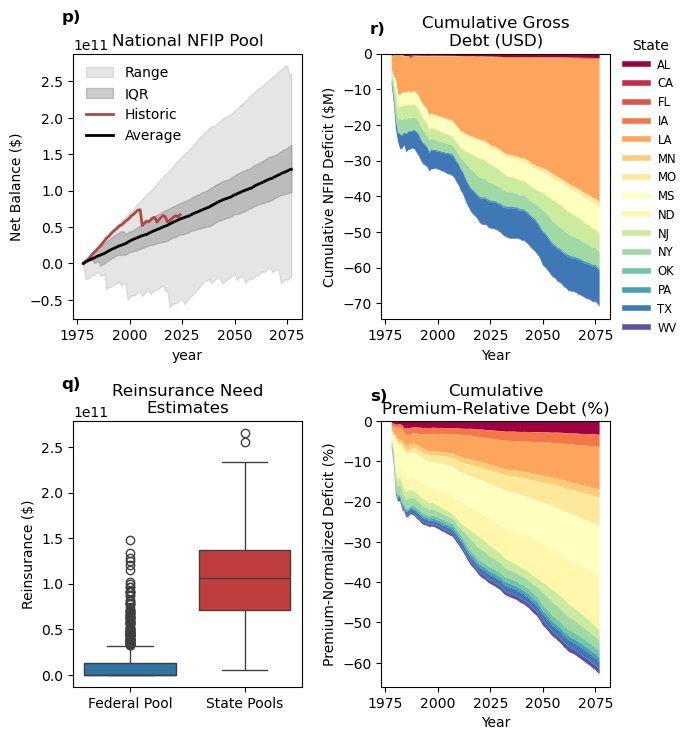

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 7.5))
panel_labels = ['p)', 'q)', 'r)', 's)']
label_offset = (-0.05, 1.12)

# ── (0,0): Time Series with min–max shading + mean line ──
ax = axs[0, 0]
ax.fill_between(
    stats_by_year['year'], stats_by_year['min'], stats_by_year['max'],
    alpha=0.2, color='gray', label='Range'
)
ax.fill_between(
    stats_by_year['year'], stats_by_year['q25'], stats_by_year['q75'],
    alpha=0.4, color='gray', label='IQR'
)
sns.lineplot(
    data=time_series_df_hist, x="year", y="total_balance",
    legend=False, ax=ax, color='#B04743', lw=2, label='Historic'
)
sns.lineplot(
    data=stats_by_year, x='year', y='mean',
    ax=ax, color='black', lw=2, label='Average'
)
ax.set_title("National NFIP Pool")
ax.set_ylabel("Net Balance ($)")
ax.text(label_offset[0], label_offset[1], panel_labels[0], transform=ax.transAxes,
        fontsize=12, fontweight='bold')
ax.legend(frameon=False)

# ── (1,0): Boxplots across simulations ──
sns.boxplot(
    data=bar_long, x="Pool", y="Amount",
    ax=axs[1, 0],
    palette={"Federal Pool": "tab:blue", "State Pools": "tab:red"}
)
axs[1, 0].set_title("Reinsurance Need\nEstimates")
axs[1, 0].set_ylabel("Reinsurance ($)")
axs[1, 0].set_xlabel("")
axs[1, 0].text(label_offset[0], label_offset[1], panel_labels[1], transform=axs[1, 0].transAxes,
               fontsize=12, fontweight='bold')

# ── RIGHT COLUMN: reuse first-row stackplots as a column ──
# Top-right: Cumulative Gross Deficit ($B)
custom_stackplot(
    axs[0, 1], pivot_df_billion,
    "Cumulative Gross\nDebt (USD)",
    "Cumulative NFIP Deficit ($M)",
    "Year",
    panel_labels[2], label_offset, colors_dict
)

# Bottom-right: Premium-Normalized Deficit
custom_stackplot(
    axs[1, 1], normalized_pivot_df,
    "Cumulative\nPremium-Relative Debt (%)",
    "Premium-Normalized Deficit (%)",
    "Year",
    panel_labels[3], label_offset, colors_dict
)

# Optional legend for states (attach to top-right axis to avoid overlap)
legend_states = list(pivot_df_billion.columns)
handles = [plt.Line2D([0], [0], color=colors_dict[s], lw=4) for s in legend_states]
axs[0, 1].legend(
    handles, legend_states, loc='center left', bbox_to_anchor=(1.02, 0.5),
    title="State", fontsize='small', title_fontsize='medium', frameon=False
)

plt.tight_layout()
plt.subplots_adjust(right=0.82)
if save:
    plt.savefig(f"Plots/New/NFIP_Summary_Facets_PLUS_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()